## Régression linéaire et Ridge distribué sur Spark

### Partie 1 : Préliminaires

In [3]:
# Importation des librairies

#from test_helper import Test
import os.path
import pandas as pd
from pyspark.mllib.regression import LabeledPoint
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
from pyspark.mllib.linalg import DenseVector
import random

### Création de la base

On va créer une matrice avec 51 variables $(Y, X_1...X_{50})$ et 500 observations.
Y est une combinaise linéaire de X1...X10 et est indépendant de X11...X50
On rajoute une bruit, epsilon suivant une loi normale N(0, 50)

In [36]:
np.random.seed(1)
dim=1000
x = np.random.rand(dim, 20)*100
beta = list(range(1,11)) + [0] * 10
eps = np.random.normal(0,1,size=dim)
y = x.dot(beta) + eps
mat = np.c_[y,x]

In [24]:
data=sc.parallelize(mat) # On crée un RDD à partir de la matrice mat

print(np.all(data.first()==mat[0])) # Test si on a bien la même chose (pour la première observation)
nb_obs = data.count()
print(nb_obs) # Nombre d'observations

True
500


In [25]:
# Fonction qui renvoie - un labeledPoint ie le label de l'observation
#                      - l'ensemble des features de l'observation

def feat_label_fun(line):
    return LabeledPoint(line[0], line[1:])


In [26]:
# On recup les features et le label de la première observation à titre d'exemple
obs = data.take(1) # Sort les valeurs du rdd 
obs_labelisee = list(map(feat_label_fun, obs)) # on applique la fonction feat_label_fun au rdd
features = obs_labelisee[0].features # on recupère les features
label = obs_labelisee[0].label # on recupère les labels
print("features: {0}".format(features))
print("label: {0}".format(label))

features: [41.7022004703,72.0324493442,0.0114374817345,30.2332572632,14.6755890817,9.23385947688,18.6260211378,34.5560727043,39.6767474231,53.8816734003,41.9194514403,68.5219500397,20.4452249732,87.8117436391,2.73875931979,67.0467510178,41.7304802367,55.8689828446,14.0386938595,19.8101489085,80.0744568676,96.8261575719,31.3424178159,69.2322615669,87.6389152296,89.4606663504,8.50442113698,3.90547832329,16.9830419565,87.8142503429,9.83468338331,42.1107625005,95.7889530151,53.3165284973,69.187711395,31.5515631006,68.6500927682,83.4625671897,1.82882773442,75.0144314945,98.8861088906,74.816565438,28.0443992064,78.9279328451,10.3226006578,44.7893526176,90.8595503093,29.3614148374,28.7775338586,13.0028572118]
label: 1739.42242546


In [27]:
# Même chose avec la base complète
data_labelisee = data.map(feat_label_fun)
labels = data_labelisee.map(lambda x: x.label)
features = data_labelisee.map(lambda x: x.features)

- On sépare les données en train et test (70%, 30%)
- On va utiliser la fonction cache puisque nous allons accéder à ces RDD plusieurs fois pendant l'apprentissage (et donc gain de temps)

In [28]:
weights = [.7, 0.3]
seed = 1
train, test = data_labelisee.randomSplit(weights, seed)
train.cache() 
test.cache()
n_train = train.count()
n_test = test.count()

print (n_train, n_test)
np.all(n_train + n_test==nb_obs) # On vérifie que la taille des deux jeux de données est égale à celle de
                                         # la base complète

(342, 158)


True

In [29]:
def squared_error(label, prediction):
    """ Permet de calculer l'erreur de prédiction pour une observation"""
    return (label - prediction)**2

def calcRMSE(labels_and_preds):
    """Calcule le "Root mean squared error" d'un `RDD` (label, prediction)"""
    return np.sqrt(labels_and_preds.map(lambda x: squared_error(x[0], x[1])).mean())

### Partie 2 : Régression Linéaire

Nous allons désormais effectuer une régression linéaire. Nous allons entrainer notre modèle en utilisant une descente de gradient : 

$$ \scriptsize \mathbf{\beta}_{i+1} = \mathbf{\beta}_i - \alpha_i \sum_j (\mathbf{\beta}_i^\top\mathbf{x}_j  - y_j) \mathbf{x}_j \,.$$ où $ \scriptsize i $ est le nombre d'itération 

- On implemente tout d'abord la fonction calculant de façon matricielle : $ \scriptsize (\mathbf{w}^\top \mathbf{x}_j - y_j) \mathbf{x}_j \, ,$ 

In [30]:
def gradient_summand(beta, lp):
    return (beta.dot(lp.features) - lp.label) * lp.features

- Désormais on implemente la fonction `get_labeled_predictions` qui prend les coefficients et les observations (LabeledPoint) en input et retourne un tuple (label, prediction).

In [31]:
def get_labeled_prediction(beta, observation):
    return (observation.label, beta.T.dot(observation.features))

On implemente désormais la descente de gradient qui utilise les deux fonctions précédentes. Cette fonction prend en entrée une base d'apprentissage, un nombre d'itérations et alpha, le pas et retourne l'erreur commise sur cette base ainsi que les beta finaux. 
A chaque itération i, celle-ci calcule l'erreur RMSE sur la base. Notons qu'à la première itération, les $\beta$ sont fixés à 0, ainsi le label n'est pas relié au features et le modèle prédit 0. L'erreur commise est donc potentiellement très grande.

In [32]:
def linreg_gradient_descent(train_data, num_iters, alpha):
    
    n = train_data.count()                           # le nombre d'observation de la base train_data
    d = len(train_data.take(1)[0].features)          # le nombre de features 
    beta = np.zeros(d)                                  # poids initiaux fixés à 0
    error_train = np.zeros(num_iters)
    
    for i in range(num_iters):
        labels_and_preds_train = train_data.map(lambda x: get_labeled_prediction(beta, x))
        error_train[i] = calcRMSE(labels_and_preds_train)

        gradient = train_data.map(lambda x: gradient_summand(beta, x)).sum()       # calcul du gradient
        alpha_i = alpha / (n * np.sqrt(i+1))                                    # mise à jour du pas
        beta = beta - alpha_i * gradient                                              # mise à jour des poids
        
    return beta, error_train

In [22]:
# create a toy dataset with n = 10, d = 3, and then run 5 iterations of gradient descent
# note: the resulting model will not be useful; the goal here is to verify that
# linregGradientDescent is working properly
exampleN = 3
exampleD = 10
example_data = (sc.parallelize(train.take(exampleN))
               .map(lambda lp: LabeledPoint(lp.label, lp.features[0:exampleD])))
#print("example data")
#print(example_data.take(2))
example_num_iters = 500
alpha = 0.0001
example_weights, example_error_train = linreg_gradient_descent(example_data, example_num_iters, alpha)
#print("example weight")
#print(example_weights)
#print(example_error_train)

Now let's train a linear regression model on all of our training data and evaluate its accuracy on the validation set.  Note that the test set will not be used here.  If we evaluated the model on the test set, we would bias our final results.

You have already done much of the required work: you computed the number of features; you created the training and validation datasets and computed their sizes; and you wrote a function to compute RMSE.

In [33]:
num_iters = 500
alpha = 0.0001
now = time.time()
weightsLR0, error_trainLR0 = linreg_gradient_descent(train, num_iters, alpha)
print(time.time()-now)

labels_and_preds = test.map(lambda x: get_labeled_prediction(weightsLR0, x))
rmse_valLR0 = calcRMSE(labels_and_preds)

print('Validation RMSE')
print(rmse_valLR0)

35.2144680023
Validation RMSE
54.704707901


In [34]:
print(weightsLR0)

[  1.06692666e+00   1.77243769e+00   2.88443862e+00   3.94207168e+00
   5.12882857e+00   5.72133512e+00   6.36776746e+00   7.45845114e+00
   8.20449417e+00   9.38981744e+00   9.34879411e-02  -1.02898511e-02
   3.75279599e-01   1.29082420e-01   3.87167599e-03  -2.60264999e-02
   5.18177485e-02  -8.46749959e-02   1.20839825e-01   9.46102733e-02
   2.95747910e-02  -3.24014283e-01   1.65071193e-01   2.26096843e-01
  -1.06421116e-01   3.39203735e-01   3.15582358e-01  -1.01833497e-01
  -1.04786123e-01   1.56473513e-01   3.03941067e-01   2.97982947e-01
   3.82466762e-02   1.63354586e-01  -1.53558480e-02  -2.19561393e-01
  -1.26842317e-02  -6.85992802e-02   1.21106336e-01   1.50584624e-01
  -1.33511621e-01   1.24631679e-01   1.76233655e-01   1.24650913e-01
   1.71925963e-01  -1.10793891e-01  -4.31562098e-03  -1.20255944e-01
   4.56008573e-01   3.11726764e-01]


We will look at the log of the training error as a function of iteration. The first scatter plot visualizes the logarithm of the training error for all 50 iterations.  The second plot shows the training error itself, focusing on the final 44 iterations.

In [ ]:
def prepare_plot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
cmap = get_cmap('YlOrRd')

norm = Normalize()
prenorm = Normalize()
clrs = cmap(np.asarray(norm(np.log(error_trainLR0))))[:,0:3]

fig, ax = prepare_plot(np.arange(0, 60, 10), np.arange(0, 1, 1))
ax.set_ylim(-1, 1)
plt.scatter(range(0, num_iters), np.log(error_trainLR0), s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xlabel('Iteration'), ax.set_ylabel(r'$\log_e(error_trainLR0)$')
pass

In [ ]:
norm = Normalize()
clrs = cmap(np.asarray(norm(error_trainLR0[6:])))[:,0:3]

fig, ax = prepare_plot(np.arange(0, 200, 10), np.arange(0, 210, 50))
ax.set_ylim(0, 200)
plt.scatter(range(0, num_iters-6), error_trainLR0[6:], s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xticklabels(map(str, range(0, 200, 10)))
ax.set_xlabel('Iteration'), ax.set_ylabel(r'Training Error')
pass

### Regression linéaire avec Mllib

In [15]:
from pyspark.mllib.regression import LinearRegressionWithSGD

num_iters=200
alpha = 0.0005  # step
mini_batch_frac = 1.0  # prend toute la base pour la descente de gradient (pas d'aléa)
reg = 0  # lambda
reg_type = 'none'  # pas de regularisation
use_intercept = False  # pas d'intercept

In [16]:
now = time.time()
modele_lineaire = LinearRegressionWithSGD.train(train, iterations=num_iters, step=alpha,
                                           miniBatchFraction=mini_batch_frac, regParam=reg,
                                           regType=reg_type, intercept=use_intercept)
print(time.time()-now)

# weightsLR1 stores the model weights; interceptLR1 stores the model intercept
beta_lineaire = modele_lineaire.weights
print beta_lineaire


/Users/noemiehaouzi/spark-2.0.2-bin-hadoop2.7/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


4.14531207085
[-8.95934318863e+158,-9.43163382163e+158,-8.90364480367e+158,-9.14978149653e+158,-9.62630753779e+158,-8.93095071675e+158,-9.2817076451e+158,-9.02410167264e+158,-9.34232191555e+158,-9.12002980337e+158,-9.16945538796e+158,-9.25838767941e+158,-8.46507944178e+158,-8.88487001702e+158,-9.67179266607e+158,-9.16002591742e+158,-8.85608989682e+158,-8.70169762331e+158,-9.53908329378e+158,-9.1970206925e+158,-8.8591975944e+158,-9.21808734671e+158,-9.14644578375e+158,-8.92509119649e+158,-9.00217813651e+158,-8.92434166335e+158,-8.86536713075e+158,-8.89033205959e+158,-8.90376433308e+158,-9.65325626342e+158,-9.31697365382e+158,-9.19923742604e+158,-8.99096451224e+158,-9.13446252925e+158,-9.60800834687e+158,-9.09311930439e+158,-8.88120854807e+158,-9.02127275369e+158,-8.98499383595e+158,-9.44060953446e+158,-8.89042088268e+158,-9.04434484695e+158,-8.73182422019e+158,-9.05378916977e+158,-9.04134275856e+158,-9.05635014813e+158,-9.16818294147e+158,-9.42098739919e+158,-9.17726224349e+158,-9.41408

In [85]:
labels_and_preds = test.map(lambda x: (x.label, modele_lineaire.predict(x.features)))
rmse_test_lineaire = calcRMSE(labels_and_preds)

print("RMSE")
print(rmse_test_lineaire)

RMSE
1.29046620562


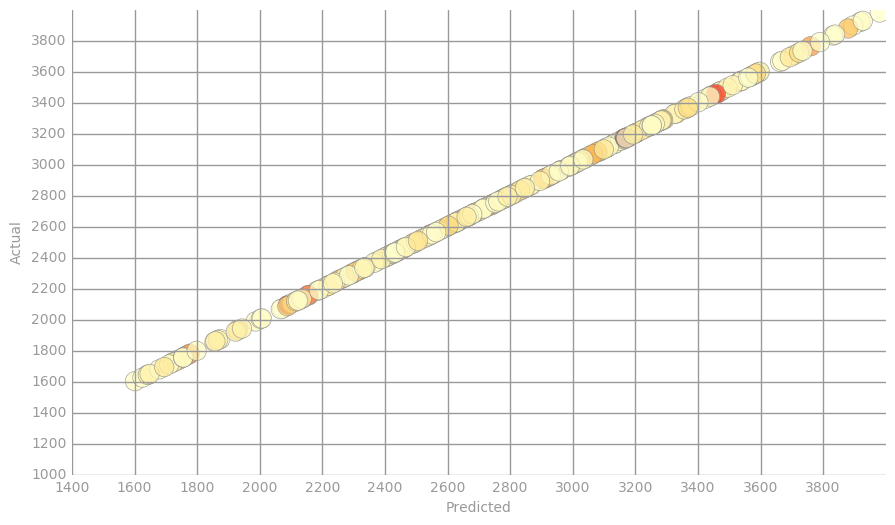

In [82]:
predictions = np.asarray(test
                         .map(lambda lp: modele_lineaire.predict(lp.features))
                         .collect())
actual = np.asarray(test
                    .map(lambda lp: lp.label)
                    .collect())
error = np.asarray(test
                   .map(lambda lp: (lp.label, modele_lineaire.predict(lp.features)))
                   .map(lambda (l, p): squared_error(l, p))
                   .collect())

norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = prepare_plot(np.arange(0, 4000, 200), np.arange(0, 4000, 200))
ax.set_xlim(1400, 4000), ax.set_ylim(1000, 4000)
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=.5)
ax.set_xlabel('Predicted'), ax.set_ylabel(r'Actual')
pass

### Partie 3 : Régression Ridge

Dans cette partie, nous ajoutons une pénalisation de type L2 à la descente de gradient. Ainsi, l'estimateur de $\beta$ par ridge par la régularisation L2 est solution de :
$$ \hat{\beta}^{ridge} = \underset{\beta}{\text{arg min}}  \sum_{i=1}^n (y_i - x_i'\beta)^2 + \lambda \sum_{j=1}^p \beta_j^2  $$
où $\lambda$ désigne le niveau de pénalité : si $\lambda$ tend vers 0, on retrouve l'estimateur des moindres carré. La relation à implémenter pour la descente de gradient associée à ce problème de minimisation est donc la suivante :
$$ \mathbf{\beta}_{i+1} = \mathbf{\beta}_i - \alpha_i \sum_j (\beta_i' x_j  - y_j) \mathbf{x}_j + \lambda \beta$$ 
Nous allons implémenter la descente de gradient associée à cette nouvelle fonction à minimiser. Elle prend en input à nouveau, la base d'apprentissage, le nombre d'itérations à accomplir, le pas $\alpha$ et le paramètre $\lambda$.


In [ ]:
def descente_gradient_ridge(train_data, num_iters, alpha, lambda_param):
    """Calculates the weights and error for a linear regression model trained with gradient descent.

    Note:
        `DenseVector` behaves similarly to a `numpy.ndarray` and they can be used interchangably
        within this function.  For example, they both implement the `dot` method.

    Args:
        trainData (RDD of LabeledPoint): The labeled data for use in training the model.
        numIters (int): The number of iterations of gradient descent to perform.

    Returns:
        (np.ndarray, np.ndarray): A tuple of (weights, training errors).  Weights will be the
            final weights (one weight per feature) for the model, and training errors will contain
            an error (RMSE) for each iteration of the algorithm.
    """
    # The length of the training data
    n = train_data.count()
    #print(n)
    # The number of features in the training data
    d = len(train_data.take(1)[0].features)
    w = np.zeros(d)
    alpha = alpha
    # We will compute and store the training error after each iteration
    error_train = np.zeros(num_iters)
    for i in range(num_iters):
        # Use getLabeledPrediction from (3b) with trainData to obtain an RDD of (label, prediction)
        # tuples.  Note that the weights all equal 0 for the first iteration, so the predictions will
        # have large errors to start.
        labels_and_preds_train = train_data.map(lambda x: get_labeled_prediction(w, x))
        error_train[i] = calcRMSE(labels_and_preds_train)

        # Calculate the `gradient`.  Make use of the `gradientSummand` function you wrote in (3a).
        # Note that `gradient` sould be a `DenseVector` of length `d`.
        gradient = train_data.map(lambda x: gradient_summand(w, x)).sum()
        gradient = gradient + lambda_param * w

        # Update the weights
        alpha_i = alpha / (n * np.sqrt(i+1))
        w -= alpha_i * gradient
        #print(w)
        #print(alpha_i)
    return w, error_train

# create a toy dataset with n = 10, d = 3, and then run 5 iterations of gradient descent
# note: the resulting model will not be useful; the goal here is to verify that
# linregGradientDescent is working properly
exampleN = 200
exampleD = 10
example_data = (sc
               .parallelize(train.take(exampleN))
               .map(lambda lp: LabeledPoint(lp.label, lp.features[0:exampleD])))
example_num_iters = 500
example_weights, example_error_train = descente_gradient_ridge(example_data, example_num_iters, 0.0001, 0.5)
print(example_weights)
print("error_train")
print(error_train)


### Grid search avec descente de gradient ridge

In [ ]:
range_lambda = [0.01, 0.02, 0.03, 0.04, 0.05]

weights = [.2, 0.8]
seed = 123
fold1, fold2 = train.randomSplit(weights, seed)

fold1.cache() #pour que ce soit plus rapide...
fold2.cache()

alpha=0.0001
num_iters = 200
bestRMSE = 100000

tmp = [fold1, fold2]
erreur_moy = np.empty([len(range_lambda), 2])
erreur_moy[:,0] = range_lambda
j=0
for reg in range_lambda:
    #rmse = []
    for i in [0,1]:
        train_tmp = tmp[i]
        val_tmp = tmp[-i]
        w, erreur = descente_gradient_ridge(train_tmp, num_iters, alpha, reg)
        labels_and_preds = val_tmp.map(lambda x: get_labeled_prediction(w, x))
        print(calcRMSE(labels_and_preds))
        rmse.append(calcRMSE(labels_and_preds))
        
    erreur_moy[j,1] = sum(rmse)/2.0        
    print(j)
    j = j+1

print(erreur_moy)
bestRMSE = min(erreur_moy[:,1])
print(bestRMSE)
best_reg_param = erreur_moy[np.argmin(erreur_moy[:,1]),0]
print(best_reg_param)

### Ridge avec MLlib

In [92]:
num_iters=200
alpha = 0.0005  # step
mini_batch_frac = 1.0  # miniBatchFraction
reg = 0.5  # lambda
reg_type = 'l2'  # regularisation avec la norme L2
use_intercept = False  # intercept

In [93]:
now = time.time()
modele_L2 = LinearRegressionWithSGD.train(train, iterations=num_iters, step=alpha,
                                           miniBatchFraction=mini_batch_frac, regParam=reg,
                                           regType=reg_type, intercept=use_intercept)
print(time.time()-now)

# weightsLR1 stores the model weights; interceptLR1 stores the model intercept
beta_L2 = modele_L2.weights
print beta_L2


1.08483719826
[1.00240463749,2.00647035393,2.99361026269,4.00324193214,5.00238016096,6.00410522273,6.98651801215,8.00040102116,9.00131664892,9.99217005346]


In [94]:
labels_and_preds = test.map(lambda x: (x.label, modele_L2.predict(x.features)))
rmse_test_L2 = calcRMSE(labels_and_preds)

print("RMSE")
print(rmse_test_L2)

RMSE
1.18474832832


### Grid search avec mllib

In [ ]:
range_lambda = [0.01, 0.1, 0.5, 0.7, 1, 1.5, 2]

weights = [.2, 0.8]
seed = 123
fold1, fold2 = train.randomSplit(weights, seed)

fold1.cache() #pour que ce soit plus rapide...
fold2.cache()

num_iters=200
alpha = 0.0005  # step
mini_batch_frac = 1.0  # miniBatchFraction
reg = 0.5  # lambda
reg_type = 'l2'  # regularisation avec la norme L2
use_intercept = False  # interceptbestRMSE = 100000

tmp = [fold1, fold2]
erreur_moy = np.empty([len(range_lambda), 2])
erreur_moy[:,0] = range_lambda
j=0

now = time.time()
for reg in range_lambda:
    rmse = []
    for i in [0,1]:
        train_tmp = tmp[i]
        val_tmp = tmp[-i]
        modele = LinearRegressionWithSGD.train(train, iterations=num_iters, step=alpha,
                                           miniBatchFraction=mini_batch_frac, regParam=reg,
                                           regType=reg_type, intercept=use_intercept)
        labels_and_preds = test.map(lambda x: (x.label, modele.predict(x.features)))
        rmse.append(calcRMSE(labels_and_preds))
        
    erreur_moy[j,1] = sum(rmse)/2.0        
    print(j)
    j = j+1
print(time.time()-now)
    
print(erreur_moy)
bestRMSE_mllib = min(erreur_moy[:,1])
print(bestRMSE_mllib)
best_reg_param_mllib = erreur_moy[np.argmin(erreur_moy[:,1]),0]
print(best_reg_param_mllib)